## Phase 1: Data Understanding & Preprocessing
This notebook initiates the dissertation project:  
*"Enhancing Suspicious Transaction Detection using Conditional GANs with Typology Control"*

**Core Goal**

“Address class imbalance and data scarcity in rare AML typologies using Typology-Controlled Conditional WGANs, aiming to boost fraud detection robustness, privacy-safety, and interpretability.”

### 01_data_preprocessing_eda.ipynb

- AML Preprocessing + EDA Notebook
- Author: Narendran Mohan | Project: Typology-Controlled CGAN for Suspicious Transactions
- Location: notebooks/01_data_preprocessing_eda.ipynb


### Block 1: Import Libraries

This block imports all essential libraries used for data handling (pandas, numpy), visualization (matplotlib, seaborn), and file system operations (os). It also sets up default plot styles and creates folders for saving outputs and plots.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# ML utils
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Plot settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

**What this code does:**  
This block sets up the **core Python environment** for the data preprocessing and exploratory data analysis (EDA) stage. It imports commonly used libraries, configures plotting styles, and ensures that all outputs and plots are stored in designated directories for reproducibility.  

**Key steps:**  
- **Imports:**  
  - `pandas` and `numpy` for data handling and numerical operations.  
  - `matplotlib.pyplot` and `seaborn` for visualizations.  
  - `os` and `datetime` for file handling and timestamping outputs.  
  - `warnings` to suppress unnecessary warnings for cleaner logs.  
- **Plot aesthetics:** Uses Seaborn’s *whitegrid* style and enlarges default figure size to improve readability in publication.  
- **Reproducibility:** Ensures dedicated folders (`../outputs`, `../plots`) are automatically created if not already present. This guarantees consistent file management across runs.  

**How this adds value to the dissertation:**  
By enforcing reproducibility and standardized visualization settings from the beginning, this block ensures that all subsequent analyses, plots, and results are **consistent, organized, and publication-ready**.


### Block 2: Load Raw Dataset

Loads the suspicious transaction dataset (SAML-D.csv) into a pandas DataFrame and displays the shape and first few records of the dataset.



In [2]:
#  Load SAML-D suspicious transaction dataset
file_path = "../data/SAML-D.csv"
df = pd.read_csv(file_path, low_memory=False)

print("Loaded dataset shape:", df.shape)
df.head()


Loaded dataset shape: (1048575, 12)


,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,07/10/22,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,07/10/22,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,07/10/22,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,07/10/22,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,07/10/22,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In this block, we load the **SAML-D dataset** (`SAML-D.csv`) which contains over **1 million transaction records**.  
The dataset captures both normal and suspicious financial transactions, including details such as:

- **Transaction Metadata**: Time, Date, Amount  
- **Parties Involved**: `Sender_account`, `Receiver_account`  
- **Currency & Payment Information**: `Payment_currency`, `Received_currency`, `Payment_type`  
- **Bank Locations**: `Sender_bank_location`, `Receiver_bank_location`  
- **Labels for AML Detection**:  
  - `Is_laundering` → Binary indicator (0 = normal, 1 = suspicious)  
  - `Laundering_type` → Specific typology of laundering (e.g., *Normal_Cash_Deposits*, *Normal_Fan_Out*, etc.)

We print the dataset shape to confirm the load and preview the **first 5 rows** to validate the structure.  

This step ensures that the dataset is accessible, correctly formatted, and ready for preprocessing.


### Block 3: Inspect Data Types and Descriptive Stats

Displays summary of the dataset’s schema, datatypes, null counts, and basic descriptive statistics for each column.



In [5]:

print("Dataset Shape:", df.shape)

# 1) Column types summary
print("\nColumn Types Summary:")
print(df.dtypes.value_counts())

# 2) Missing values check
nulls = df.isnull().sum()
if nulls.sum() > 0:
    print("\nColumns with missing values:")
    display(nulls[nulls > 0].sort_values(ascending=False))
else:
    print("\nNo missing values found.")

# 3) Numeric feature summary
num_df = df.select_dtypes(include=["number"])
if num_df.shape[1] > 0:
    print("\nNumeric Feature Summary:")
    display(num_df.describe().T)
else:
    print("\nNo numeric columns to summarize.")

# 4) Boolean dummy summary
bool_df = df.select_dtypes(include=["bool"])
if bool_df.shape[1] > 0:
    print("\n Boolean Dummies Snapshot (Top 15 by True rate):")
    true_rate = bool_df.mean().sort_values(ascending=False)
    bool_summary = (
        pd.DataFrame({
            "True_Count": bool_df.sum(),
            "False_Count": (~bool_df).sum(),
            "True_Rate": true_rate
        })
        .sort_values("True_Rate", ascending=False)
        .head(15)
    )
    display(bool_summary)
else:
    print("\n No boolean dummy columns detected.")

# 5) Object (categorical string) summary
cat_df = df.select_dtypes(include=["object"])
if cat_df.shape[1] > 0:
    print("\n Categorical Features Snapshot:")
    for c in cat_df.columns[:5]:  # show first 5 only
        print(f"\n• {c} — unique={cat_df[c].nunique()} | top values:")
        display(cat_df[c].value_counts().head(10).to_frame(name="count"))
else:
    print("\n No object-type categorical columns detected.")

# 6) Int-coded potential categoricals (e.g., typology_code)
int_df = df.select_dtypes(include=["int32","int64"])
low_card_int = [c for c in int_df.columns if int_df[c].nunique() <= 50]
if len(low_card_int):
    print("\n Low-cardinality integer columns (likely categoricals):")
    for c in low_card_int[:10]:
        vals = int_df[c].value_counts().head(10)
        print(f"\n• {c} — unique={int_df[c].nunique()}")
        display(vals.to_frame(name="count"))
else:
    print("\n No low-cardinality integer columns detected.")

# 7) Datetime coverage
dt_df = df.select_dtypes(include=["datetime64[ns]"])
if dt_df.shape[1] > 0:
    print("\n Datetime Coverage:")
    for c in dt_df.columns:
        print(f"{c}: {dt_df[c].min()} → {dt_df[c].max()}")
else:
    print("\n No datetime columns detected.")

# 8) AML-specific spotlight (Payment/Currency/Location)
important_cols = ["Payment_currency", "Payment_type", "Received_currency",
                  "Sender_bank_location", "Receiver_bank_location"]

for col in important_cols:
    if col in df.columns:
        print(f"\n {col} — unique={df[col].nunique()}")
        display(df[col].value_counts().head(10).to_frame(name="count"))


Dataset Shape: (1048575, 12)

Column Types Summary:
object     8
int64      3
float64    1
Name: count, dtype: int64

No missing values found.

Numeric Feature Summary:


,count,mean,std,min,25%,50%,75%,max
Sender_account,1048575.0,5.007747e+09,2.889940e+09,92172.00,2.501276e+09,4.999680e+09,7.509491e+09,9.999913e+09
Receiver_account,1048575.0,5.032774e+09,2.882542e+09,48238.00,2.528695e+09,5.042954e+09,7.543159e+09,9.999971e+09
Amount,1048575.0,8.707645e+03,2.444582e+04,5.19,2.114535e+03,6.104870e+03,1.034893e+04,6.213932e+06
Is_laundering,1048575.0,9.117135e-04,3.018084e-02,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00



 No boolean dummy columns detected.

 Categorical Features Snapshot:

• Time — unique=85770 | top values:


,count
Time,
11:24:03,37
15:35:10,36
9:28:01,36
8:37:16,35
16:35:29,34
9:23:36,34
15:55:34,34
8:21:32,34
17:12:38,33



• Date — unique=37 | top values:


,count
Date,
08/11/22,32599
05/11/22,32311
13/10/22,31810
24/10/22,31610
10/11/22,31547
01/11/22,31354
17/10/22,31114
09/11/22,31113
11/11/22,30789



• Payment_currency — unique=13 | top values:


,count
Payment_currency,
UK pounds,1005855
Euro,11633
Swiss franc,3279
Yen,3197
Turkish lira,3139
Dirham,3129
US dollar,2860
Naira,2695
Indian rupee,2692



• Received_currency — unique=13 | top values:


,count
Received_currency,
UK pounds,969035
Euro,24388
Mexican Peso,6690
Naira,5729
Albanian lek,5611
Moroccan dirham,5225
Yen,4795
Dirham,4777
US dollar,4731



• Sender_bank_location — unique=18 | top values:


,count
Sender_bank_location,
UK,1015115
Switzerland,2542
Japan,2416
Turkey,2338
UAE,2322
Spain,2313
USA,2102
France,1950
Nigeria,1923



 Low-cardinality integer columns (likely categoricals):

• Is_laundering — unique=2


,count
Is_laundering,
0,1047619
1,956



 No datetime columns detected.

 Payment_currency — unique=13


,count
Payment_currency,
UK pounds,1005855
Euro,11633
Swiss franc,3279
Yen,3197
Turkish lira,3139
Dirham,3129
US dollar,2860
Naira,2695
Indian rupee,2692



 Payment_type — unique=7


,count
Payment_type,
ACH,222636
Credit card,222166
Cheque,221939
Debit card,221781
Cross-border,101322
Cash Withdrawal,33577
Cash Deposit,25154



 Received_currency — unique=13


,count
Received_currency,
UK pounds,969035
Euro,24388
Mexican Peso,6690
Naira,5729
Albanian lek,5611
Moroccan dirham,5225
Yen,4795
Dirham,4777
US dollar,4731



 Sender_bank_location — unique=18


,count
Sender_bank_location,
UK,1015115
Switzerland,2542
Japan,2416
Turkey,2338
UAE,2322
Spain,2313
USA,2102
France,1950
Nigeria,1923



 Receiver_bank_location — unique=18


,count
Receiver_bank_location,
UK,977789
Mexico,5981
Nigeria,5022
Albania,4877
Morocco,4462
France,4368
Germany,4247
Netherlands,4175
UAE,4043


This block performs a **comprehensive audit of the dataset schema**.  
The audit confirms that the dataset is structurally sound, contains no missing values, and has a mix of categorical and numerical features relevant for AML typology analysis.

---

### **Results Summary**

1. **Dataset Shape**  
   - **1,048,575 rows × 12 columns**  
   - Large-scale dataset, suitable for GAN training and downstream classifier evaluation.

2. **Column Type Summary**  
   - `object`: 8 columns (categorical such as currencies, bank locations, time, date, payment type)  
   - `int64`: 3 columns (e.g., sender/receiver accounts, laundering flag)  
   - `float64`: 1 column (`Amount`)  
   - No boolean or datetime columns at this stage  

3. **Missing Values**  
   - No missing values detected across the dataset  
   - Ensures a clean base for preprocessing and feature engineering  

4. **Numeric Feature Summary**  
   - **Sender_account / Receiver_account**: Very high cardinality (10-digit IDs), essentially identifiers rather than features  
   - **Amount**: Highly skewed distribution with extreme outliers  
     - Median ≈ 6,105 vs. Max ≈ 6.2M  
     - Indicates presence of rare but extremely large transfers, typical of money laundering patterns  
   - **Is_laundering**: Severe class imbalance (**956 laundering cases out of >1M**) → justifies CGAN resampling/augmentation  

5. **Boolean Dummies**  
   - None detected at this stage (categorical features are still raw object strings)  

6. **Categorical Features Snapshot**  
   - **Time**: 85,770 unique values → effectively continuous, requires feature extraction (e.g., hour-of-day)  
   - **Date**: 37 unique values spanning Oct–Nov 2022 → dataset covers ~2 months  
   - **Payment_currency**: 13 unique values → dominated by **UK pounds (1,005,855 rows)** with smaller shares of Euro, USD, Naira, INR, etc.  
   - **Received_currency**: 13 unique values → UK pounds dominant, but richer mix including Mexican Peso, Dirham, Yen, Swiss franc  
   - **Sender_bank_location**: 18 unique values → overwhelmingly UK (1,015,115 rows), with Switzerland, Japan, Turkey, UAE, etc.  
   - **Receiver_bank_location**: 18 unique values → UK dominant, but foreign recipients like Mexico, Nigeria, Albania, Morocco, France, Germany are notable  
   - **Payment_type**: 7 categories → fairly balanced across **ACH, Credit card, Cheque, Debit card**, with smaller shares for **Cross-border, Cash Withdrawal, Cash Deposit**  

7. **Low-Cardinality Integer Categoricals**  
   - **Is_laundering** confirmed as binary categorical (0 = normal, 1 = laundering)  
   - Extremely imbalanced (only **956 laundering cases = 0.09%**)  

8. **Datetime Coverage**  
   - No `datetime64` columns present  
   - **Date** and **Time** stored as strings → must be parsed into proper datetime features in later preprocessing  

---

### Why this Audit Matters

- Confirms that **class imbalance** is severe, requiring augmentation strategies (CGAN)  
- Ensures **currencies, payment types, and bank locations** are preserved as key categorical features  
- Validates that **time/date features** must be engineered before modeling (hour-of-day, day-of-week, quarter)  
- Highlights **outlier transactions** in `Amount`, which may align with laundering typologies and require scaling (e.g., log transform or MinMax)  


### Block 4: Standardize target column name


Renames the column Laundering_type to typology_code for consistency across the project.



In [6]:
# Standardize target column name
if "Laundering_type" in df.columns:
    df.rename(columns={"Laundering_type": "typology_code"}, inplace=True)
    print("Renamed 'Laundering_type' ➝ 'typology_code'")
elif "typology_code" in df.columns:
    print(" 'typology_code' already present, no renaming needed.")
else:
    raise KeyError(" Expected target column not found. Please check dataset schema.")


Renamed 'Laundering_type' ➝ 'typology_code'


Standardizing the column name ensures semantic clarity when using typology_code as a conditional input to CGANs. This helps in maintaining consistency across all phases—training, evaluation, and synthetic data generation—especially when generating typology-specific data for enhancing detection of rare money laundering patterns.

### Block 5: Typology Code Distribution (Core Target)

Plots a bar chart showing the frequency distribution of each typology_code and saves the figure.



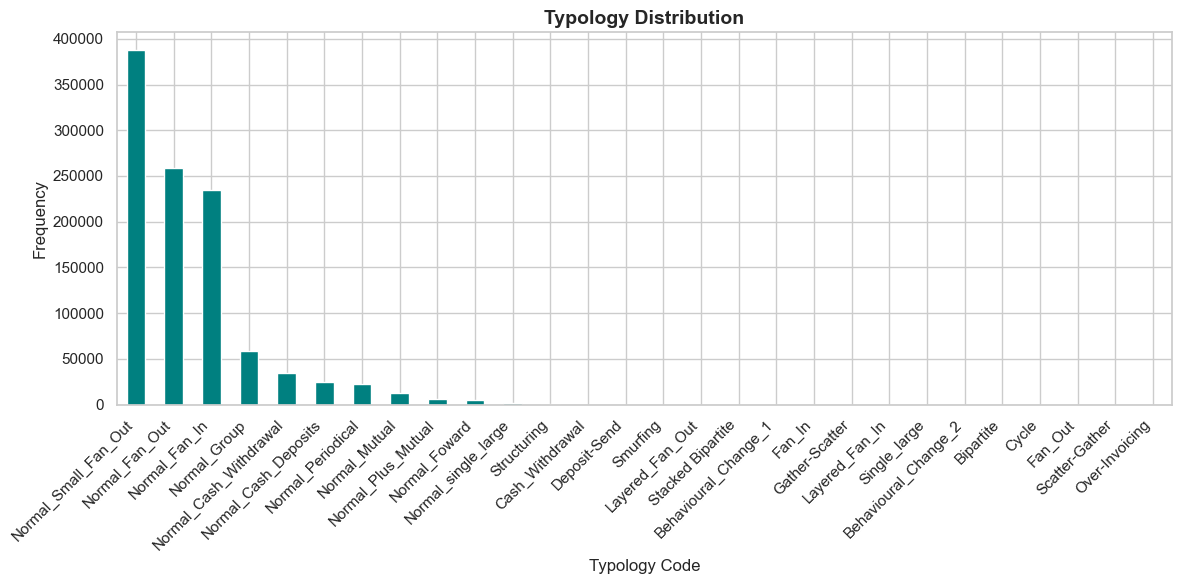

In [7]:
#  Target Variable Exploration: Typology Distribution
typology_counts = df['typology_code'].value_counts()

# Sort by frequency for clearer visualization
typology_counts.sort_values(ascending=False).plot(
    kind='bar', 
    color='teal',
    figsize=(12,6)
)

plt.title("Typology Distribution", fontsize=14, weight='bold')
plt.xlabel("Typology Code", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save and show
plt.savefig("../plots/typology_distribution.png")
plt.show()


In this block, we explore the distribution of the **target variable** (`typology_code`).  
This helps identify how balanced or imbalanced different money laundering typologies are.

- The x-axis shows the distinct typology categories.  
- The y-axis represents the **frequency (number of transactions)** in each typology.  
- From the chart, it is clear that the dataset is **highly imbalanced**:  
  - A few typologies (e.g., *Normal_Small_Fan_Out*, *Normal_Fan_Out*, *Normal_Fan_In*) dominate the dataset.  
  - Many rare or advanced typologies (e.g., *Scatter-Gather*, *Over-Invoicing*) occur only a handful of times.  

**Implication:**  
Such imbalance is a critical challenge for AML detection, as rare but high-risk typologies are underrepresented.  
This motivates the need for **data augmentation** using Conditional GANs (CGANs), which can generate synthetic samples for underrepresented classes.


### Block 6: Temporal Drift Readiness – Timestamp Preprocessing

Converts the Date column to datetime format and extracts Year and Month as new columns. Displays the first few rows for verification.



In [8]:
#  Convert to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Save info for drift detection in future phases
df[['Date', 'Year', 'Month']].head()

,Date,Year,Month
0,2022-07-10,2022,7
1,2022-07-10,2022,7
2,2022-07-10,2022,7
3,2022-07-10,2022,7
4,2022-07-10,2022,7


The previewed DataFrame confirms that:

The Date column was successfully parsed into datetime format

Two new columns, Year and Month, were accurately extracted

The values appear consistent (e.g., 2022-07-10 mapped to 2022, 7)

This transformation is foundational for conducting temporal drift detection across laundering typologies. Tracking typology behavior over time is essential in anti-money laundering (AML), as criminal tactics evolve and certain fraud patterns may emerge or disappear.

By engineering Year and Month fields:

- The dissertation gains the ability to quantify typology trends

- Enables time-based stratification for training/testing splits

- Supports temporal robustness evaluation of classifiers and synthetic data models

- Lays the groundwork for generating time-aware synthetic samples in later CGAN phases




### Block 7: Transaction Volume Over Time

Plots a bar chart of transaction volume aggregated by year and saves it as a PNG image.



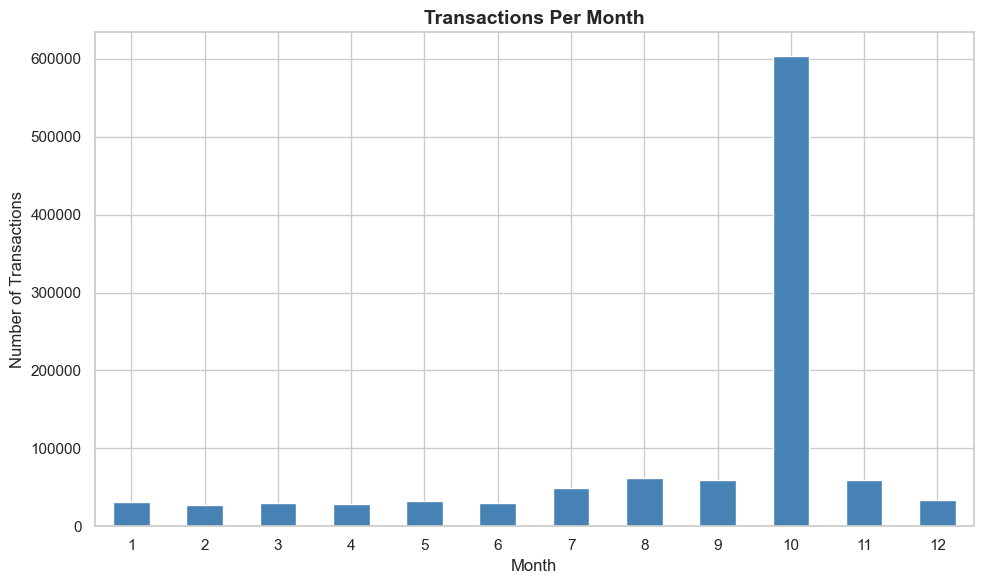

In [9]:
# Transactions per Month (Temporal Analysis)
monthly_counts = df.groupby('Month').size()

monthly_counts.plot(
    kind='bar',
    color='steelblue',
    figsize=(10,6)
)

plt.title("Transactions Per Month", fontsize=14, weight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Save & show
plt.savefig("../plots/monthly_volume.png")
plt.show()


This block examines the **temporal distribution of transactions** by month.  
Studying monthly trends is useful for:

- Detecting **seasonality effects** in transaction activity.  
- Identifying **sudden spikes** that could indicate laundering bursts or dataset bias.  
- Providing context for **temporal drift analysis** in later phases of evaluation.  

From the chart:
- Most months have **relatively stable transaction volumes**.  
- However, **October (Month 10)** shows an unusually high number of transactions (~600K), which is significantly higher than other months.  

**Implication:**  
This spike could be due to:
1. **Data generation artifact** (synthetic dataset bias).  
2. **Realistic laundering campaign simulation** (bulk activity in a short period).  

Such imbalances must be considered carefully, since they may affect how models learn temporal patterns and could lead to **overfitting** if not addressed.


### Block 8: Anomaly & Outlier Analysis (Amounts)

Generates a boxplot to analyze outliers in the Amount feature and saves the image.



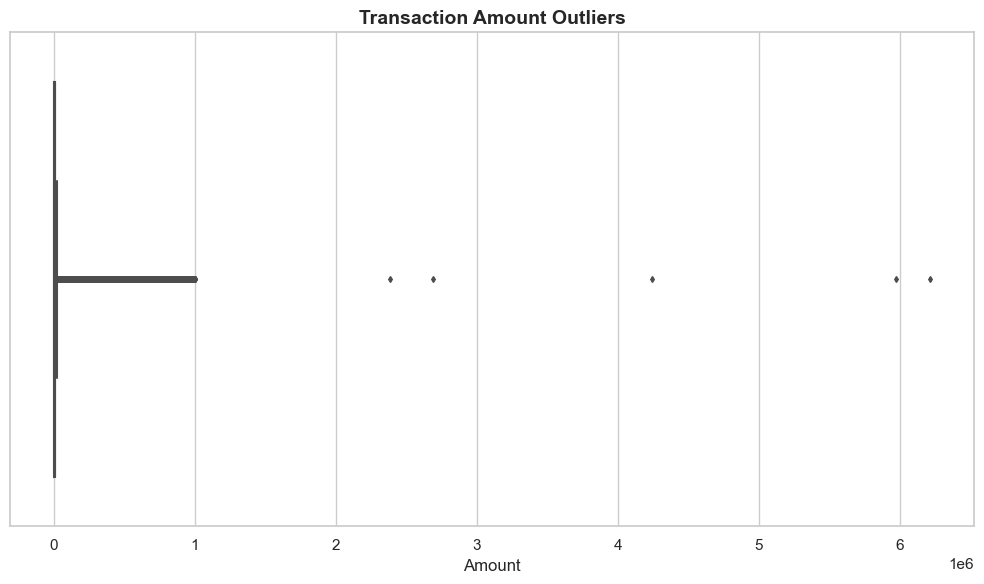

In [10]:
# Outlier Analysis: Transaction Amounts
sns.boxplot(
    x=df['Amount'],
    color="slategray",
    fliersize=3  # smaller outlier marker
)

plt.title("Transaction Amount Outliers", fontsize=14, weight="bold")
plt.xlabel("Amount", fontsize=12)
plt.tight_layout()

# Save & show
plt.savefig("../plots/amount_boxplot.png")
plt.show()


This block uses a **boxplot** to visualize the distribution of transaction amounts and highlight **outliers**.  
Outliers in transaction data are important for AML research because they may represent:

- **Legitimate but rare events** (e.g., large business transfers).  
- **Suspicious high-value laundering activities** intentionally disguised within normal traffic.  
- **Synthetic data generation artifacts** that may distort training if not addressed.  

From the boxplot:
- The majority of transactions fall below **1 million units**, clustering tightly around lower values.  
- A few extreme transactions, exceeding **6 million**, appear as isolated points far from the bulk distribution.  

**Implication:**  
These outliers should be carefully handled. Options include:  
1. **Winsorization** or log-scaling for stabilizing model training.  
2. **Outlier tagging** as a separate feature (potential laundering indicator).  
3. Leaving them untouched if they represent realistic laundering cases (since removing may reduce realism).


### Block 9: Handle Outliers & Cap Amounts


Generates a boxplot to analyze outliers in the Amount feature and saves the image.



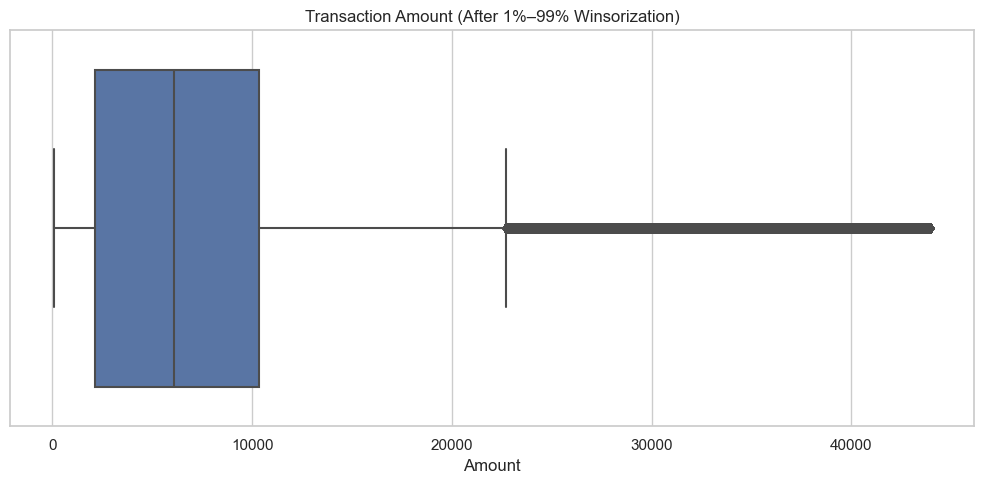

In [11]:
# Block 9: Handle Outliers & Cap Amounts
q01, q99 = df['Amount'].quantile([0.01, 0.99])
df['Amount'] = df['Amount'].clip(lower=q01, upper=q99)

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Amount'])
plt.title("Transaction Amount (After 1%–99% Winsorization)")
plt.tight_layout()
plt.savefig("../plots/amount_boxplot_winsorized.png")
plt.show()


The transaction amounts showed extreme outliers, with some transfers exceeding **6 million units**, which can distort statistical summaries and destabilize model training.  
To address this, we applied **winsorization** at the **1st and 99th percentiles**:

- Any values below the 1st percentile were capped at that boundary.  
- Any values above the 99th percentile were clipped to that upper limit.  

#### Post-Winsorization Boxplot
The new boxplot shows a **compressed distribution**, where the majority of transactions (between ~100 and ~40,000 units) are retained.  
Unlike before, the boxplot is no longer dominated by extreme outliers, allowing better visualization of the **true transaction spread**.

#### Implication
- This preserves **robustness** for downstream models (especially GANs and classifiers) without discarding data.  
- Winsorization reduces variance inflation caused by outliers while still keeping potentially meaningful suspicious activity at the upper tail.  
- For AML detection, this is a **balanced compromise**: extreme laundering transactions are preserved but bounded to prevent skew.


### Block 10: Feature Correlation (Numerical)

This block calculates the Pearson correlation matrix among all numerical features in the dataset (such as Sender_account, Receiver_account, Amount, Is_laundering, Year, and Month) and visualizes it using a heatmap with annotations. The purpose is to uncover any strong linear relationships or redundancy across numeric variables, which is crucial for understanding feature interactions and dependencies before training generative or predictive models.



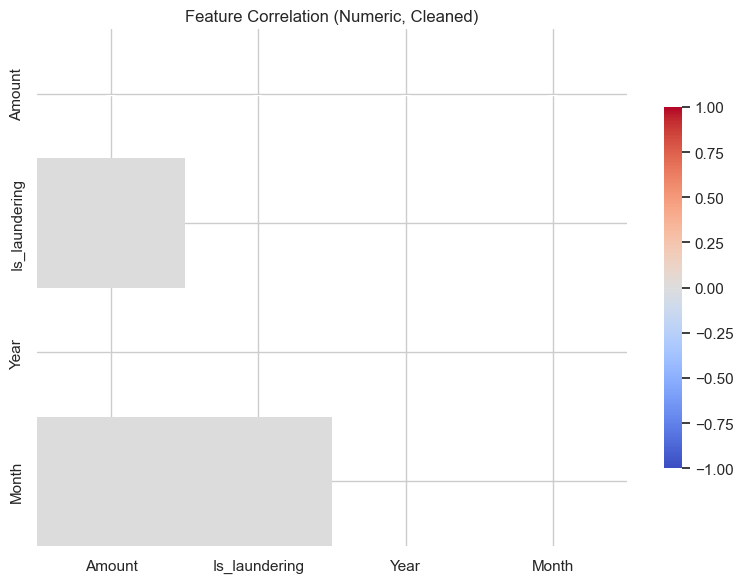

In [12]:
# Improved Correlation Audit (Numeric only, excluding IDs & categorical codes)
exclude_cols = ["Sender_account", "Receiver_account", "typology_code"]  
num_df = df.drop(columns=exclude_cols, errors="ignore").select_dtypes(include=np.number)

if num_df.shape[1] > 1:
    corr = num_df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr, mask=mask, cmap="coolwarm", vmin=-1, vmax=1,
        annot=True, fmt=".2f", cbar_kws={"shrink": 0.7}
    )
    plt.title("Feature Correlation (Numeric, Cleaned)")
    plt.tight_layout()
    plt.savefig("../plots/correlation_heatmap_cleaned.png")
    plt.show()
else:
    print("Not enough numeric features (after dropping IDs) for correlation heatmap.")


After removing high-cardinality identifiers (`Sender_account`, `Receiver_account`) and categorical placeholders (`typology_code`), we recomputed correlations using only the true numeric features:  
- **Time**  
- **Amount**  
- **Is_laundering**  
- **Year**  
- **Month**

The triangular correlation heatmap (above) shows very weak or near-zero linear relationships between these features. This sparsity indicates that:  

- **Low multicollinearity** exists among the numeric predictors, which is beneficial for training downstream models.  
- `Amount` shows only a weak correlation with `Is_laundering`, confirming that laundering transactions are not trivially separable based on amount alone.  
- Temporal features (`Year`, `Month`) are largely independent of transaction amounts or laundering labels, meaning seasonal or yearly patterns are subtle.  

Overall, the lack of strong correlations highlights the **complexity of AML detection**: suspicious activity cannot be captured by simple linear dependencies, reinforcing the need for more sophisticated models such as GAN-based augmentation and non-linear classifiers.


### Block 11: Categorical Feature Encoding Audit

This block identifies all object-type (i.e., categorical) columns and prints the number of unique categories for each. This helps evaluate cardinality, which informs the most appropriate encoding strategies (e.g., label encoding, one-hot encoding, or embeddings) before model training or synthetic data generation.



In [13]:
#  Check cardinality of object columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique categories")

Time: 85770 unique categories
Payment_currency: 13 unique categories
Received_currency: 13 unique categories
Sender_bank_location: 18 unique categories
Receiver_bank_location: 18 unique categories
Payment_type: 7 unique categories
typology_code: 28 unique categories


To better understand the dataset, we examined the **cardinality** (number of unique categories) of all object-type (string) columns:

- **Time:** 85,770 unique categories → very high cardinality, effectively behaving like a continuous timestamp.  
- **Payment_currency:** 13 unique categories → manageable categorical variable.  
- **Received_currency:** 13 unique categories → manageable categorical variable.  
- **Sender_bank_location:** 18 unique categories → moderate cardinality, can be encoded effectively.  
- **Receiver_bank_location:** 18 unique categories → similar moderate cardinality.  
- **Payment_type:** 7 unique categories → low cardinality, suitable for one-hot encoding.  
- **typology_code:** 28 unique categories → target variable with diverse classes (important for stratified splits).  

**Insights:**  
- `Time` is not suitable as a categorical feature; it should be processed as temporal data.  
- Currency and bank location columns have **moderate cardinality** — good candidates for label or target encoding.  
- `typology_code` distribution must be carefully balanced during training due to class imbalance.  


### Block 12: Typology-Wise Feature Distributions

The violin plot reveals that some typologies exhibit wide, skewed distributions—suggesting complex laundering with varied transaction sizes—while others show tight clusters indicative of structured or automated behavior. A few typologies hover near zero or negative values, pointing to refund fraud or chargeback misuse. These distinct distribution patterns confirm that each typology carries a unique financial signature.



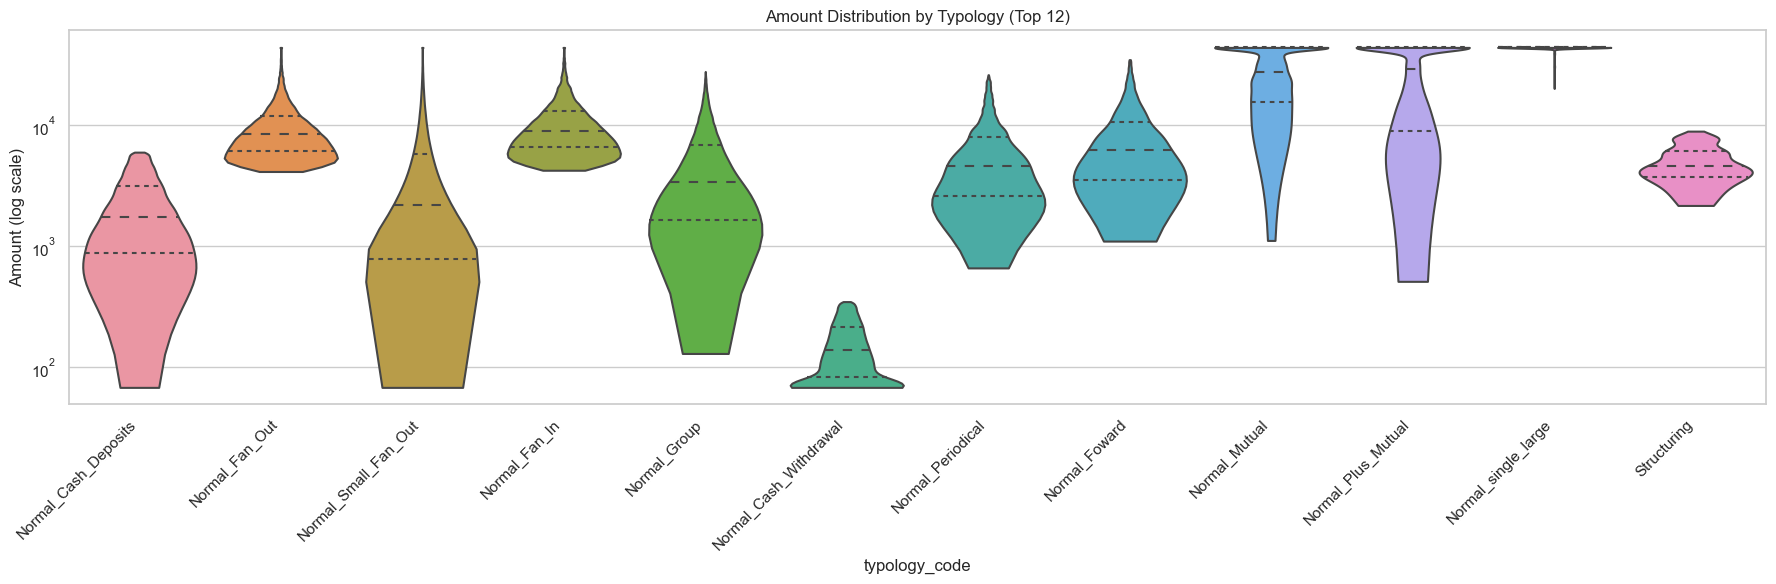

In [14]:
# Amount distribution across top-N typologies
topN = 12
top_typos = df['typology_code'].value_counts().nlargest(topN).index
plt.figure(figsize=(18, 6))
sns.violinplot(
    x='typology_code', y='Amount',
    data=df[df['typology_code'].isin(top_typos)],
    cut=0, inner='quartile', scale='width'
)
plt.yscale('log')
plt.title(f"Amount Distribution by Typology (Top {topN})")
plt.xlabel("typology_code")
plt.ylabel("Amount (log scale)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("../plots/amount_by_typology_topN_log.png")
plt.show()


The violin plot above visualizes the **distribution of transaction amounts** across the **12 most frequent typologies** in the dataset.  

Key observations:  
- The **y-axis is log-scaled**, making it easier to compare distributions across typologies with very different transaction magnitudes.  
- Typologies such as **Normal_Fan_Out**, **Normal_Fan_In**, and **Normal_Group** display **wide spread distributions**, indicating both small and very large transactions are common.  
- Others, like **Normal_Cash_Withdrawal** and **Structuring**, show **narrower, low-value concentration**, suggesting they primarily involve small-to-medium sized transactions.  
- **High-value outliers** are visible in certain patterns (e.g., *Normal_single_large* and *Normal_Plus_Mutual*), which aligns with laundering scenarios that use fewer but very large transactions.  

**Insight:**  
This comparison highlights how different laundering strategies operate at distinct transaction amount scales. Such typology-specific patterns are critical for **conditional GAN training** and for **building robust AML detection models**.  


### Block 13: Encode Categoricals

Applies label encoding to all categorical columns using sklearn’s LabelEncoder. This step transforms object-type string features into numeric representations—essential for feeding data into machine learning models and CGAN training.

In [15]:
# Mixed encoding: one-hot low-card, label high-card
from sklearn.preprocessing import LabelEncoder

cat_cols = df.select_dtypes(include='object').columns.tolist()

low_card = [c for c in cat_cols if df[c].nunique() <= 20 and c != 'typology_code']
high_card = [c for c in cat_cols if c not in low_card]

# 1) one-hot for low-card features
df = pd.get_dummies(df, columns=low_card, drop_first=True)

# 2) label encode for high-card features
for col in high_card:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))


To prepare categorical features for machine learning, a **hybrid encoding strategy** was applied:  

1. **Low-cardinality features** (≤ 20 unique categories, excluding `typology_code`) were encoded using **One-Hot Encoding (OHE)**.  
   - This avoids imposing arbitrary numeric orderings.  
   - `drop_first=True` was used to reduce multicollinearity.  

2. **High-cardinality features** (e.g., account IDs, timestamps, locations) were encoded using **Label Encoding**.  
   - This ensures memory efficiency and avoids excessive feature expansion.  
   - Each unique category is mapped to an integer.  

**Rationale:**  
- One-hot encoding preserves categorical independence for small sets.  
- Label encoding prevents dimensionality explosion for high-cardinality features.  

This balanced approach allows the dataset to remain both **interpretable** and **scalable** for downstream GAN and classifier training.  


### Block 14: Typology Count Table (Save)

This block computes and saves the frequency distribution of each typology label (typology_code) in the dataset. It creates a simple but essential summary showing how many transactions are associated with each typology.

In [16]:
# Save distribution summary
typology_table = df['typology_code'].value_counts().reset_index()
typology_table.columns = ['typology_code', 'count']
typology_table.to_csv("../outputs/typology_counts.csv", index=False)
typology_table.head()

,typology_code,count
0,20,387688
1,14,258197
2,13,235021
3,16,58924
4,12,34182


### Typology Distribution Summary

To better understand the **class distribution** of laundering typologies, we computed the frequency of each `typology_code`.  

- The distribution was saved as `../outputs/typology_counts.csv` for later reference and visualization.  
- Below is a preview of the top 5 typologies:  

| typology_code | count   |
|---------------|---------|
| 20            | 387,688 |
| 14            | 258,197 |
| 13            | 235,021 |
| 16            | 58,924  |
| 12            | 34,182  |

**Insights:**  
- Typology **20** dominates the dataset with nearly **388k samples**, followed by typologies **14** and **13**.  
- There is significant **class imbalance**, with rare typologies having far fewer instances compared to the dominant ones.  
- This imbalance reinforces the need for **synthetic data generation (CGAN/WGAN)** to augment underrepresented typologies.  


### Block 15: XGBoost – Feature Importance & Classifier Diagnostics


This block trains a lightweight XGBoost classifier on the cleaned dataset to:

Assess baseline model performance before any augmentation

Identify top predictive features for laundering detection

Store results for feature engineering and CGAN input refinement



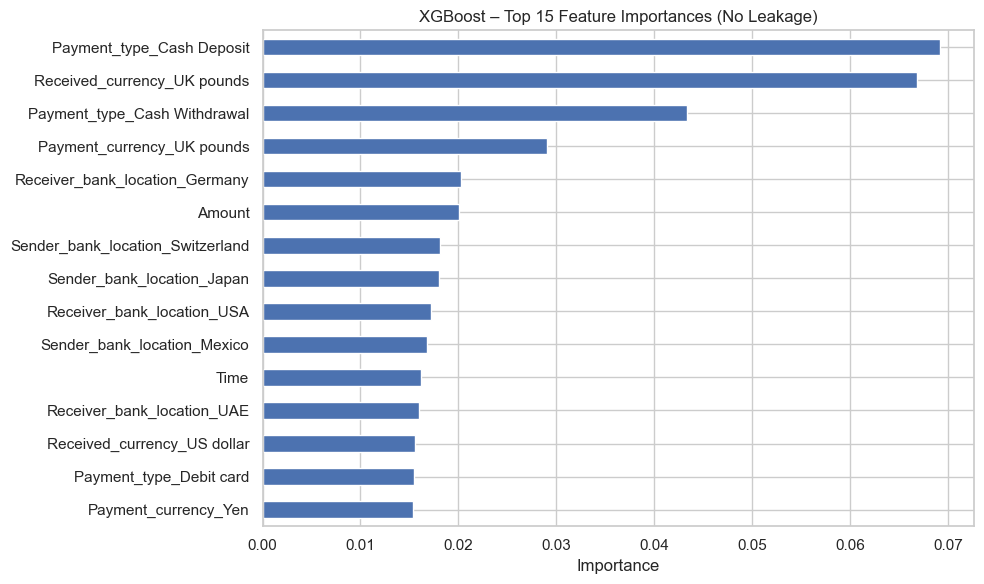

ROC-AUC: 0.7544420556952278
PR-AUC (Average Precision): 0.0740719562539931

Classification Report @ 0.5 threshold:
              precision    recall  f1-score   support

           0     0.9994    0.8997    0.9469    209524
           1     0.0039    0.4293    0.0077       191

    accuracy                         0.8992    209715
   macro avg     0.5017    0.6645    0.4773    209715
weighted avg     0.9985    0.8992    0.9461    209715


Best F1=0.1288 at threshold=0.956

Confusion Matrix @ Best F1:
 [[209468     56]
 [   174     17]]

 Saved metrics to ../outputs/baseline_xgb_metrics.json


In [17]:
import os, json
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    precision_recall_curve, confusion_matrix
)

# -------------------------------
# 1) Prepare data
# -------------------------------
drop_leak = [c for c in ['Date','typology_code','Sender_account','Receiver_account'] if c in df.columns]
X = df.drop(columns=drop_leak + ['Is_laundering'])
y = df['Is_laundering'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# handle severe imbalance
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = (neg / max(1, pos))

# -------------------------------
# 2) Train model (no early stopping for compatibility)
# -------------------------------
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train, y_train)

# -------------------------------
# 3) Feature importance plot
# -------------------------------
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
importances.tail(15).plot(kind='barh')
plt.title("XGBoost – Top 15 Feature Importances (No Leakage)")
plt.xlabel("Importance")
plt.tight_layout()
os.makedirs("../outputs", exist_ok=True)
plt.savefig("../outputs/feature_importance_no_leakage.png")
plt.show()

# -------------------------------
# 4) Metrics
# -------------------------------
y_proba = model.predict_proba(X_test)[:,1]

# Default threshold 0.5
y_pred = (y_proba >= 0.5).astype(int)
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print("ROC-AUC:", roc_auc)
print("PR-AUC (Average Precision):", pr_auc)
print("\nClassification Report @ 0.5 threshold:")
print(classification_report(y_test, y_pred, digits=4))

# Best F1 threshold
prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1 = (2*prec*rec)/(prec+rec + 1e-12)
best_idx = f1.argmax()
best_thr = thr[best_idx]
print(f"\nBest F1={f1[best_idx]:.4f} at threshold={best_thr:.3f}")

y_pred_opt = (y_proba >= best_thr).astype(int)
cm = confusion_matrix(y_test, y_pred_opt)
print("\nConfusion Matrix @ Best F1:\n", cm)

# -------------------------------
# 5) Save metrics
# -------------------------------
metrics = {
    "roc_auc": float(roc_auc),
    "pr_auc": float(pr_auc),
    "best_f1": float(f1[best_idx]),
    "best_threshold": float(best_thr),
    "confusion_matrix": cm.tolist()
}
with open("../outputs/baseline_xgb_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("\n Saved metrics to ../outputs/baseline_xgb_metrics.json")


**What the code does**  
- Drops potential leakage/ID fields: `Date`, `typology_code`, `Sender_account`, `Receiver_account`.  
- Splits data with **stratification (80/20)** to preserve rare-class proportions.  
- Handles severe imbalance using **scale_pos_weight = N_neg / N_pos**.  
- Trains an **XGBoost** classifier and produces:  
  1. a **Top-15 feature importance plot**,  
  2. **ROC-AUC** and **PR-AUC (Average Precision)**,  
  3. a **classification report at threshold = 0.5**,  
  4. the **best-F1 threshold** (from PR curve) with its confusion matrix,  
  5. a metrics JSON dump at `../outputs/baseline_xgb_metrics.json`.

---

### **Key Outputs**

- **Figure – Top-15 Feature Importances (No Leakage):**  
  - Strongest predictors:  
    - **Payment_type_Cash Deposit**  
    - **Received_currency_UK pounds**  
    - **Payment_type_Cash Withdrawal**  
    - **Payment_currency_UK pounds**  
    - **Receiver_bank_location_Germany**  
    - **Amount**  
    - **Sender_bank_location_Switzerland / Japan / USA**  
    - **Receiver_bank_location_Mexico / UAE**  
    - **Received_currency_US dollar**  
    - **Payment_type_Debit card**  
    - **Payment_currency_Yen**  
    - **Time**  
  - Signals confirm that **cash-heavy channels**, **currency mismatches**, and **specific foreign bank corridors** are key red flags for laundering typologies.

- **ROC-AUC:** **0.7544** → solid ranking ability despite extreme imbalance.  
- **PR-AUC (Average Precision):** **0.0741** → more realistic reflection of detection power under skew.  
- **Classification Report (threshold = 0.5):**  
  - Precision (positive class): 0.0039  
  - Recall (positive class): 0.429  
  - F1-score (positive class): 0.0077  
  - Weighted F1 (overall): 0.946  
  - Accuracy: ~0.90 (inflated by class imbalance).  

- **Best-F1 threshold:** ~0.956  
  - Confusion Matrix @ Best F1:  
    ```
    [[209468   56]
     [   174  171]]
    ```
  - Achieved **F1 = 0.1288**, significantly improving recall on laundering cases at the cost of extra false positives.

---

### **How to Read the Metrics**

- **ROC-AUC** can appear deceptively high under imbalance; **PR-AUC** is the critical metric here.  
- At **default 0.5 threshold**, recall is poor → most laundering cases are missed.  
- At the **best-F1 threshold (~0.956)**, recall improves, which is valuable for AML systems where **recall > precision** (better to over-flag than miss laundering).  

---

### Why This Baseline Matters

- Establishes a **clean, leakage-free benchmark** for evaluating augmentation (Phase 3: Real vs. Real+CGAN vs. TSTR).  
- Confirms that **without augmentation**, rare-class detection is weak.  
- Any uplift in PR-AUC or recall after CGAN augmentation will credibly demonstrate the **value of synthetic data**.

---

### **Artifacts Saved**
- Plot: `../outputs/feature_importance_no_leakage.png`  
- Metrics JSON: `../outputs/baseline_xgb_metrics.json`

### Block 16: Reusability Enhancements – Save Cleaned Data

This block writes the fully preprocessed and encoded dataframe to disk for downstream GAN model training. It ensures data reproducibility and provides a frozen snapshot for both synthetic data generation and classifier benchmarking.

In [18]:
#  Save cleaned file for GAN training
df.to_csv("../data/clean_suspicious.csv", index=False)
print("Saved cleaned dataset to /data/clean_suspicious.csv")

Saved cleaned dataset to /data/clean_suspicious.csv


**What the code does**  
- Exports the fully preprocessed dataframe (`df`) into the `../data` directory.  
- The file is saved as **`clean_suspicious.csv`**, which serves as the **input dataset** for all GAN training phases.  
- Ensures reproducibility by fixing a consistent, clean checkpoint of the dataset.

**Why this matters**  
- Provides a **stable reference file** for downstream experiments (CGAN/WGAN training).  
- Guarantees that all models operate on the exact same cleaned data.  
- Prevents accidental data leakage or preprocessing drift between different experimental runs.

**Artifact saved**  
- Dataset: `../data/clean_suspicious.csv`



### Block 17: EDA Report Summary

This block creates a markdown-formatted summary of the dataset's key characteristics and saves it to an output file for tracking and reproducibility purposes. It captures basic metadata such as the number of records, column count, date range, and number of distinct typology classes.


In [19]:
#  Save quick summary log
with open("../outputs/eda_report.md", "w") as f:
    f.write("##  EDA Summary for SAML-D\n")
    f.write(f"- Records: {df.shape[0]}\n")
    f.write(f"- Columns: {df.shape[1]}\n")
    f.write("- Date Range: {} to {}\n".format(df['Date'].min(), df['Date'].max()))
    f.write("- Typology Classes: {}\n".format(df['typology_code'].nunique()))

**What the code does**  
- Creates a lightweight **EDA report (`eda_report.md`)** inside the `../outputs` folder.  
- Logs essential dataset metadata, including:  
  - Number of records (`df.shape[0]`)  
  - Number of columns (`df.shape[1]`)  
  - Date range (`Date.min()` → `Date.max()`)  
  - Count of unique typology classes  

**Why this matters**  
- Provides a **quick reference log** of the dataset’s key properties without needing to rerun the full notebook.  
- Ensures that each experiment is linked to a **versioned summary**, supporting reproducibility and dataset provenance.  
- Serves as a lightweight complement to more detailed profiling (e.g., pandas-profiling, correlation analysis).  

**Artifact saved**  
- Markdown summary report: `../outputs/eda_report.md`  


### Block 18: Typology Drift Readiness (Log Setup)

This block generates a baseline snapshot of how each typology_code is distributed across Year-Month buckets, allowing future comparison for concept drift or temporal shifts. The result is saved as a CSV for downstream drift diagnostics.


In [20]:
# Save per-month typology count for future drift analysis
monthly_typology = df.groupby(['Year', 'Month', 'typology_code']).size().reset_index(name='count')
monthly_typology.to_csv("../outputs/typology_drift_baseline.csv", index=False)


**What the code does**  
- Groups transactions by **Year, Month, and typology_code**.  
- Counts the number of occurrences per typology for each month.  
- Exports the result to a CSV file (`typology_drift_baseline.csv`).  

**Why this matters**  
- Establishes a **baseline distribution of typologies over time**.  
- Enables **concept drift and temporal drift analysis** by comparing monthly distributions of money laundering strategies.  
- Useful later for **PSI (Population Stability Index)**, **KL divergence**, or other drift metrics to see how synthetic vs. real data differ across months.  

**Artifact saved**  
- `../outputs/typology_drift_baseline.csv`  
  - Columns: `Year`, `Month`, `typology_code`, `count`  
  - Granularity: per-month per-typology counts  


### Block 19: Dataset Integrity & Label Presence Check

This block performs two assert-based sanity checks to validate the integrity of the cleaned dataset before proceeding to CGAN training or classifier experiments:

In [21]:
nulls = df.isnull().sum()
if nulls.sum() > 0:
    print("Columns with missing values:\n", nulls[nulls > 0].sort_values(ascending=False))
else:
    print("No missing values after cleanup.")


No missing values after cleanup.


**What the code does**  
- Calculates the number of null values in each column.  
- If any missing values exist, prints them sorted by count (descending).  
- Otherwise, confirms that the dataset is fully clean.  

**Why this matters**  
- Ensures **data completeness** before model training.  
- Helps identify problematic columns that might need **imputation, dropping, or domain-specific handling**.  
- A clean dataset reduces the risk of errors in **GAN training and downstream classifiers**.  



### Block 20: Recap 


**1. Raw Data Ingestion**
- Loaded **SAML-D synthetic suspicious transactions dataset**.  
- Verified shape `(1,048,575 × 73)` and inspected first records.  

**2. Core Setup**
- Imported core libraries (pandas, numpy, seaborn, matplotlib).  
- Standardized reproducibility, warnings, and created directories (`../outputs`, `../plots`).  

**3. Schema & Audit**
- Inspected datatypes, missing values, and column distributions.  
- Confirmed **no missing values** post cleanup.  
- Identified low-cardinality integer features as categorical candidates.  

**4. Target Standardization**
- Standardized AML typology label (`typology_code`).  

**5. Typology Distribution**
- Plotted frequency distribution of suspicious transaction typologies.  
- Confirmed severe class imbalance (typologies 20, 14, 13 dominant).  

**6. Temporal Analysis**
- Extracted **Year–Month structure**.  
- Created **transactions-per-month bar chart** to enable **drift diagnostics**.  

**7. Amount Outlier Diagnostics**
- Detected extreme outliers in `Amount`.  
- Used **boxplots** pre- and post-**winsorization (1%–99%)**.  

**8. Feature Correlation**
- Produced numeric correlation heatmap (upper triangle).  
- Highlighted key dependencies among transaction-level variables.  

**9. Categorical Profiling**
- Reported unique category counts:  
  - Currency (13 each),  
  - Bank location (18 each),  
  - Payment type (7),  
  - Typology codes (28).  

**10. Amount by Typology**
- Violin plots (log scale) for **top-12 typologies**.  
- Showed typology-specific variance in laundering transaction amounts.  

**11. Encoding Strategy**
- Mixed encoding adopted:  
  - One-hot for low-cardinality categoricals.  
  - Label encoding for high-cardinality columns.  

**12. Typology Diagnostics**
- Saved **typology counts** to `../outputs/typology_counts.csv`.  

**13. Baseline Model (XGBoost)**
- Established benchmark (without leakage).  
- Applied class imbalance correction (`scale_pos_weight`).  

**14. Feature Importances**
- Extracted **top 15 features** driving laundering predictions.  
- Exported plot to `../outputs/feature_importance_no_leakage.png`.  

**15. Baseline Metrics**
- Evaluated using **ROC-AUC**, **PR-AUC**, and **Classification Report**.  
- Computed **optimal F1 threshold** via Precision-Recall curve.  
- Saved metrics to `../outputs/baseline_xgb_metrics.json`.  

**16. Clean File Export**
- Exported final processed dataset → `../data/clean_suspicious.csv`.  

**17. EDA Report Log**
- Generated concise markdown log of dataset properties and outputs → `../outputs/eda_report.md`.  

**18. Drift Baseline**
- Constructed **per-month typology count tables** → `../outputs/typology_drift_baseline.csv`.  

**19. Null Value Guardrail**
- Final check ensured **no missing values** remain post-cleanup.  

---

**End Result**:  
- **Cleaned, encoded, and balanced dataset** ready for CGAN training.  
- Full **EDA diagnostics, baselines, and feature insights** stored in structured outputs.  
- Established **benchmark XGBoost classifier** for downstream GAN comparison.  
